## Data reading and Data Insights

**Keeping a journal Participant: aunemb9o, 32 days participation**

*Dataset:* 'Keeping a journal' vs 'Not Keeping a journal' study

#### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [3]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_keeping_a_journal_-_aunemb9o_2025-04-28 11_21_01.086//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_keeping_a_journal_-_aunemb9o_2025-04-28 11_21_01.086//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: aunemb9o
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [4]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has 2 unique values.
Unique values are: ['a94b6597-769f-4b96-b750-e9b98f62c988'
 '58a3d635-be54-48f6-b8f3-db873a85672d']


#### Participation of the study

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  58a3d635-be54-48f6-b8f3-db873a85672d                   4
1  a94b6597-769f-4b96-b750-e9b98f62c988                  29


Besides the expected participant who met the study’s criteria and participated for 32 days, another individual was observed who neither provided the necessary consent nor completed any surveys.

#### Missing Values

In [6]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),           
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 32d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant a94b6597-769f-4b96-b750-e9b98f62c988 ---

  Outcome:
    Start date:           2025-03-25
    End of expected 32d:  2025-04-25
    Expected days count:  32
    Completed days count: 27
    Missed days count:    5
    Missed dates:
       2025-03-28
       2025-04-12
       2025-04-16
       2025-04-18
       2025-04-25

  Mediators:
    Start date:           2025-03-25
    End of expected 32d:  2025-04-25
    Expected days count:  32
    Completed days count: 29
    Missed days count:    3
    Missed dates:
       2025-03-28
       2025-04-12
       2025-04-18

--- Participant 58a3d635-be54-48f6-b8f3-db873a85672d ---

  Outcome:
    Start date:           2025-04-07
    End of expected 32d:  2025-05-08
    Expected days count:  32
    Completed days count: 4
    Missed days count:    28
    Missed dates:
       2025-04-08
       2025-04-09
       2025-04-11
       2025-04-12
       2025-04-14
       2025-04-15
       2025-04-17
       2025-04-18
       2025-04-19
      

During the 32-day study period, participant "a94b6597-769f-4b96-b750-e9b98f62c988" missed the Outcome survey on five days and the Mediators survey on three days. The non-study participant "58a3d635-be54-48f6-b8f3-db873a85672d" completed both surveys on only four of those days and did not participate on the others.

#### Remove Participants Who Joined Outside the Study

In [7]:
df_mea = df_mea[df_mea['participant_id'] != "58a3d635-be54-48f6-b8f3-db873a85672d"]
df_mea.shape[0]
df_mea.tail()

,measurement_time,measurement_id,measurement_name,participant_id,participant_started_at,invite_code,current_day_of_study,current_intervention_id,current_intervention_name,survey1_id,...,survey1_question4_response,survey2_id,survey2_name,is_survey2,survey2_question1_id,survey2_question1_text,survey2_question1_response,survey2_question2_id,survey2_question2_text,survey2_question2_response
59,2025-03-27 22:33:41.346717+00:00,75d128b4-fa7f-4a5b-8608-d99694a22170,Mediators,a94b6597-769f-4b96-b750-e9b98f62c988,2025-03-24 23:00:00.000Z,NaN,2,fe5370a9-aeb4-4c5c-ae71-16b5c6991477,Keeping a journal,2c23daab-009c-45fe-ad5a-af44999d74d6,...,NaN,75d128b4-fa7f-4a5b-8608-d99694a22170,Mediators,True,e1e6ff2f-3524-49ae-9a21-35c2fb37f22c,"Based on today's circumstances, to what extent...",5.0,9a3579bf-c4bd-430a-9ce7-4d5e9fad6397,"Considering your plans and circumstances, to w...",3.0
60,2025-03-26 21:53:40.488311+00:00,2c23daab-009c-45fe-ad5a-af44999d74d6,Outcome,a94b6597-769f-4b96-b750-e9b98f62c988,2025-03-24 23:00:00.000Z,NaN,1,fe5370a9-aeb4-4c5c-ae71-16b5c6991477,Keeping a journal,2c23daab-009c-45fe-ad5a-af44999d74d6,...,1.0,75d128b4-fa7f-4a5b-8608-d99694a22170,Mediators,False,e1e6ff2f-3524-49ae-9a21-35c2fb37f22c,"Based on today's circumstances, to what extent...",NaN,9a3579bf-c4bd-430a-9ce7-4d5e9fad6397,"Considering your plans and circumstances, to w...",NaN
61,2025-03-26 21:52:31.918787+00:00,75d128b4-fa7f-4a5b-8608-d99694a22170,Mediators,a94b6597-769f-4b96-b750-e9b98f62c988,2025-03-24 23:00:00.000Z,NaN,1,fe5370a9-aeb4-4c5c-ae71-16b5c6991477,Keeping a journal,2c23daab-009c-45fe-ad5a-af44999d74d6,...,NaN,75d128b4-fa7f-4a5b-8608-d99694a22170,Mediators,True,e1e6ff2f-3524-49ae-9a21-35c2fb37f22c,"Based on today's circumstances, to what extent...",3.0,9a3579bf-c4bd-430a-9ce7-4d5e9fad6397,"Considering your plans and circumstances, to w...",7.0
62,2025-03-25 20:53:07.370546+00:00,2c23daab-009c-45fe-ad5a-af44999d74d6,Outcome,a94b6597-769f-4b96-b750-e9b98f62c988,2025-03-24 23:00:00.000Z,NaN,0,fe5370a9-aeb4-4c5c-ae71-16b5c6991477,Keeping a journal,2c23daab-009c-45fe-ad5a-af44999d74d6,...,1.0,75d128b4-fa7f-4a5b-8608-d99694a22170,Mediators,False,e1e6ff2f-3524-49ae-9a21-35c2fb37f22c,"Based on today's circumstances, to what extent...",NaN,9a3579bf-c4bd-430a-9ce7-4d5e9fad6397,"Considering your plans and circumstances, to w...",NaN
63,2025-03-25 20:51:23.363292+00:00,75d128b4-fa7f-4a5b-8608-d99694a22170,Mediators,a94b6597-769f-4b96-b750-e9b98f62c988,2025-03-24 23:00:00.000Z,NaN,0,fe5370a9-aeb4-4c5c-ae71-16b5c6991477,Keeping a journal,2c23daab-009c-45fe-ad5a-af44999d74d6,...,NaN,75d128b4-fa7f-4a5b-8608-d99694a22170,Mediators,True,e1e6ff2f-3524-49ae-9a21-35c2fb37f22c,"Based on today's circumstances, to what extent...",2.0,9a3579bf-c4bd-430a-9ce7-4d5e9fad6397,"Considering your plans and circumstances, to w...",2.0


#### Data Preperation

In [8]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-04-25 20:42:57.289313+00:00,Mediators,a94b6597-769f-4b96-b750-e9b98f62c988,31,Not keeping a journal,NaN,NaN,NaN,NaN,2.0,2.0


In [9]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [10]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [11]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
62,2025-03-25 20:53:07.370546+00:00,Outcome,a94b6597-769f-4b96-b750-e9b98f62c988,0,Keeping a journal,2.0,3.0,4.0,1.0,NaN,NaN
60,2025-03-26 21:53:40.488311+00:00,Outcome,a94b6597-769f-4b96-b750-e9b98f62c988,1,Keeping a journal,4.0,3.0,5.0,1.0,NaN,NaN
58,2025-03-27 22:35:11.591476+00:00,Outcome,a94b6597-769f-4b96-b750-e9b98f62c988,2,Keeping a journal,4.0,6.0,4.0,1.0,NaN,NaN
56,2025-03-29 20:03:42.329410+00:00,Outcome,a94b6597-769f-4b96-b750-e9b98f62c988,4,Not keeping a journal,3.0,2.0,1.0,4.0,NaN,NaN
54,2025-03-30 19:16:25.576841+00:00,Outcome,a94b6597-769f-4b96-b750-e9b98f62c988,5,Not keeping a journal,2.0,5.0,1.0,2.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)    

#### Data Shape

In [12]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 27
Columns: 11


#### Data Types of columns

In [13]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [14]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),    
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant a94b6597-769f-4b96-b750-e9b98f62c988 ---

  Outcome:
    Start date:           2025-03-25
    End of expected 16d:  2025-04-25
    Expected days count:  32
    Completed days count: 27
    Missed days count:    5
    Missed dates:
       2025-03-28
       2025-04-12
       2025-04-16
       2025-04-18
       2025-04-25

  Mediators:
    Start date:           2025-03-25
    End of expected 16d:  2025-04-25
    Expected days count:  32
    Completed days count: 29
    Missed days count:    3
    Missed dates:
       2025-03-28
       2025-04-12
       2025-04-18

  survey1_question1_response:
    Start date:           2025-03-25
    End of expected 16d:  2025-04-25
    Expected days count:  32
    Completed days count: 27
    Missed days count:    5
    Missed dates:
       2025-03-28
       2025-04-12
       2025-04-16
       2025-04-18
       2025-04-25

  survey1_question2_response:
    Start date:           2025-03-25
    End of expected 16d:  2025-04-25
    Expected

#### Missing Values for Confirmations between 08.00 - 21.00

In [15]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=16, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 16 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

Missing participation days and their corresponding task names:
          date intervention_task_name
1   2025-03-26                    NaN
14  2025-04-07                    NaN


#### Summary Statistics

In [16]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             27.000000                   27.000000   
mean              14.740741                    3.148148   
std                9.188591                    1.133534   
min                0.000000                    1.000000   
25%                7.500000                    2.000000   
50%               14.000000                    3.000000   
75%               22.000000                    4.000000   
max               30.000000                    5.000000   

       survey1_question2_response  survey1_question3_response  \
count                   27.000000                   27.000000   
mean                     4.111111                    2.666667   
std                      1.281025                    1.941451   
min                      2.000000                    1.000000   
25%                      3.000000                    1.000000   
50%                      4.000000               

In [17]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 62 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            27 non-null     datetime64[ns, UTC]
 1   measurement_name            27 non-null     object             
 2   participant_id              27 non-null     object             
 3   current_day_of_study        27 non-null     int64              
 4   current_intervention_name   27 non-null     object             
 5   survey1_question1_response  27 non-null     float64            
 6   survey1_question2_response  27 non-null     float64            
 7   survey1_question3_response  27 non-null     float64            
 8   survey1_question4_response  27 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

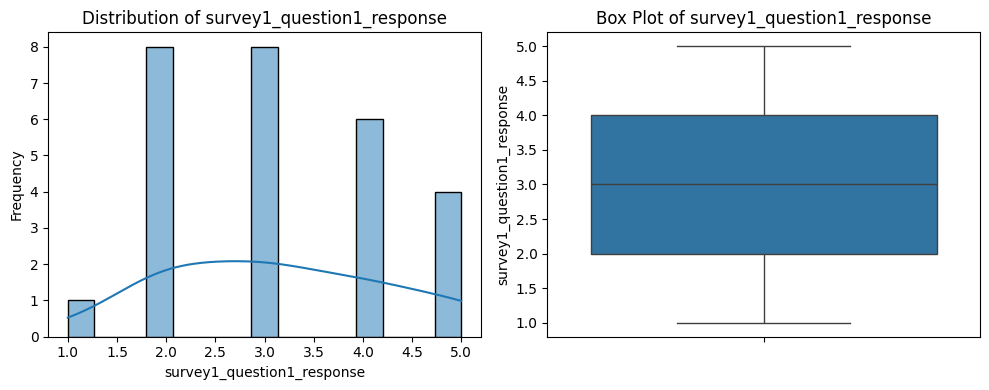

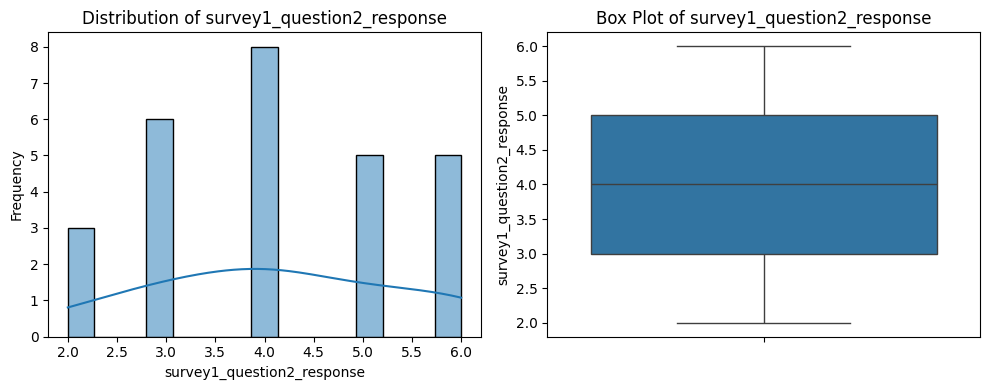

In [18]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

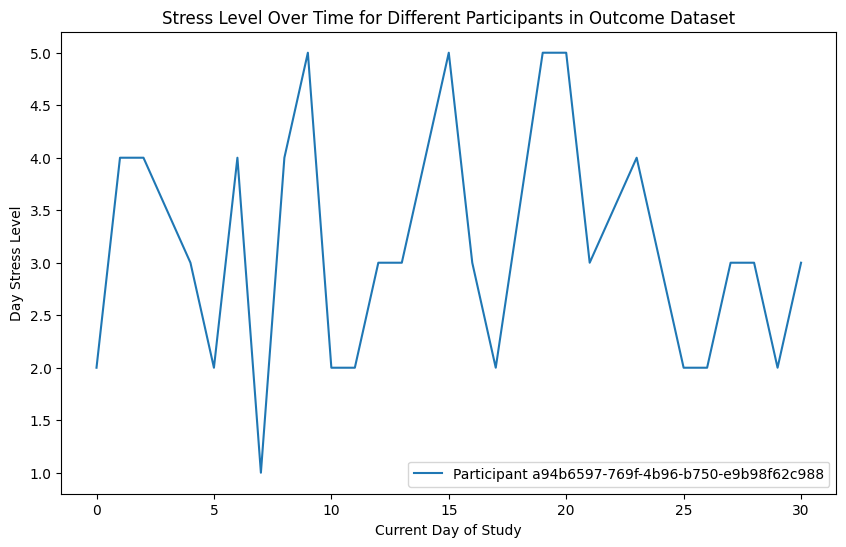

In [19]:
grouped_data = df_mea_o.groupby("participant_id")
plt.figure(figsize=(10, 6)) 

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()


#### Scatterplot

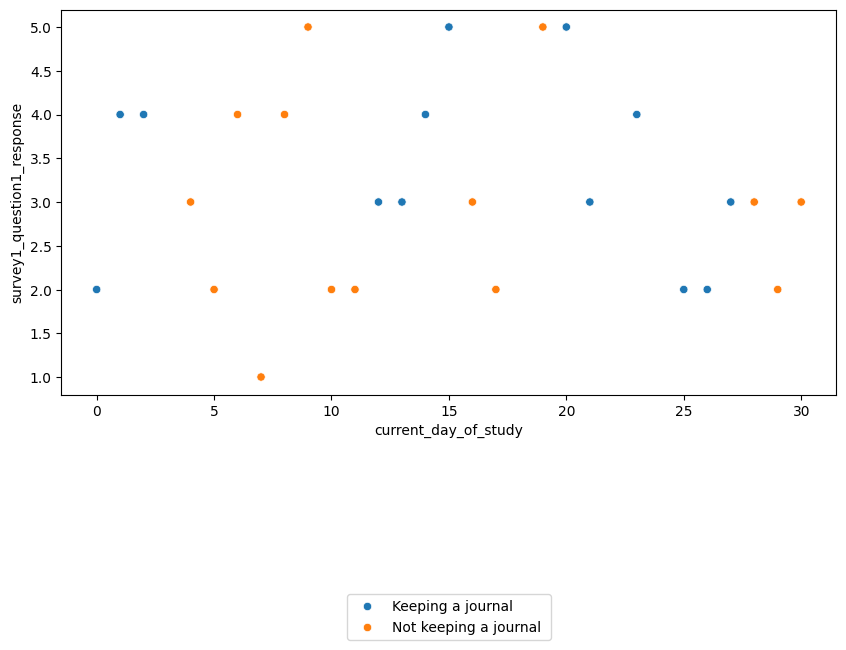

In [20]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))


#### Correlations

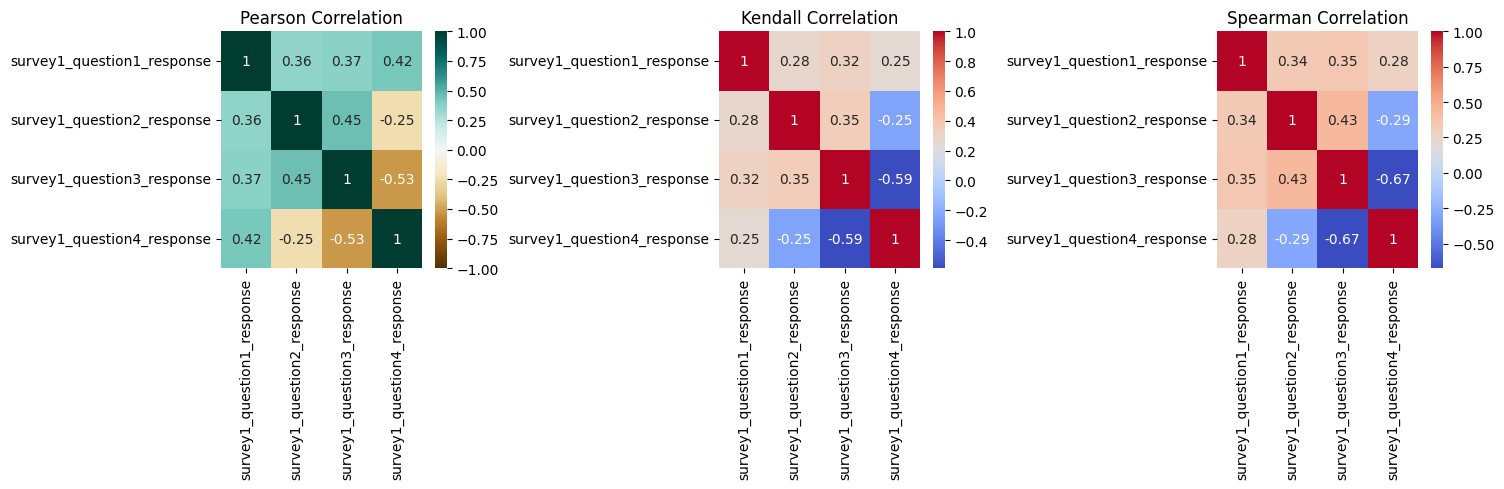

In [21]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Keeping a journal vs Not keeping a journal

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)
        - Bayesian AR(1) Regression with Consecutive‐Day Adjustment
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Mean Imputation Method
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Latent Variable Method

#### Examination of Outcomes: Today Stress Level

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Keeping a journal ",
        "Not keeping a journal "
    ])
]

watching     = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Keeping a journal ",
    'survey1_question1_response'
]
not_watching = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not keeping a journal ",
    'survey1_question1_response'
]

n_watching       = watching.count()
n_not_watching   = not_watching.count()
std_watching     = watching.std(ddof=1)
std_not_watching = not_watching.std(ddof=1)

print(f"Keeping a journal:      n = {n_watching}, std = {std_watching:.2f}, mean = {watching.mean():.2f}")
print(f"Not keeping a journal:  n = {n_not_watching}, std = {std_not_watching:.2f}, mean = {not_watching.mean():.2f}\n")

Keeping a journal:      n = 13, std = 1.04, mean = 3.38
Not keeping a journal:  n = 14, std = 1.21, mean = 2.93



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [23]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Keeping a journal ",
        "Not keeping a journal "
    ])
]


watching = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Keeping a journal ",
    'survey1_question2_response'
]
not_watching = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not keeping a journal ",
    'survey1_question2_response'
]


n_watching       = watching.count()
n_not_watching   = not_watching.count()
std_watching     = watching.std(ddof=1)
std_not_watching = not_watching.std(ddof=1)

print(f"Keeping a journal:      n = {n_watching}, std = {std_watching:.2f}, mean = {watching.mean():.2f}")
print(f"Not keeping a journal:  n = {n_not_watching}, std = {std_not_watching:.2f}, mean = {not_watching.mean():.2f}\n")

Keeping a journal:      n = 13, std = 1.39, mean = 4.62
Not keeping a journal:  n = 14, std = 1.01, mean = 3.64



#### Examination of Outcomes: Mean Stress-Relief Score for Karaoke (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much keeping a journal alleviated participants’ stress on days they performed.

In [24]:
df_mea.survey1_question3_text[0]

'If you applied the stress management method today, how effective was it in helping you feel better about yourself? (Answer only if you have kept a journal.) '

In [25]:
# 'If you applied the stress management method today, how effective was it in helping you feel better about yourself? (Answer only if you have kept a journal.) '

mean_q3_journal = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Keeping a journal ",
    'survey1_question3_response'
].mean()
mean_q3_journal.item()

4.461538461538462

**Mean Stress-Relief Score for Keeping a Journal: 4.46:**
On days when the participant kept a journal, she rated Question 3—“If you applied the stress management method today, how effective was it in helping you feel better about yourself?”—an average of **4.46 out of 10**, indicating only a slight boost, yet given her generally low stress levels, this still suggests that journaling had a meaningful impact on her stress management.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Journal (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not write a journal.

In [26]:
df_mea.survey1_question4_text[0]

'When you did not use the stress management method, did you notice any difficulty in managing your stress levels? (Answer only when a journal is not kept!) '

In [27]:
# 'When you did not use the stress management method, did you notice any difficulty in managing your stress levels? (Answer only when a journal is not kept!) '
mean_q4_journal = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not keeping a journal ",
    'survey1_question4_response'
].mean()
mean_q4_journal.item()

2.7142857142857144

**Mean Stress-Management Difficulty Score Without Journaling: 2.71:**
On days when the participant did not keep a journal, she rated Question 4—“When you did not use the stress management method, did you notice any difficulty in managing your stress levels?”—an average of **2.71 out of 10**, indicating she experienced only a slight challenge in managing her stress.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [28]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Keeping a journal ", "Not keeping a journal "])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Keeping a journal ").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.042
Model:                                    OLS   Adj. R-squared:                  0.004
Method:                         Least Squares   F-statistic:                     1.095
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.305
Time:                                17:34:34   Log-Likelihood:                -40.607
No. Observations:                          27   AIC:                             85.21
Df Residuals:                              25   BIC:                             87.81
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [29]:
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.066
Model:                                  GLSAR   Adj. R-squared:                  0.027
Method:                         Least Squares   F-statistic:                     1.706
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.204
Time:                                17:34:34   Log-Likelihood:                -38.709
No. Observations:                          26   AIC:                             81.42
Df Residuals:                              24   BIC:                             83.93
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

#### Bayesian AR(1) Model of Daily Stress Response to Keeping a Journal and Mediators

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 152 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.384  0.408    -0.418      1.170      0.016    0.015     694.0   
rho       0.016  0.198    -0.355      0.403      0.007    0.007     825.0   
sigma     1.168  0.160     0.900      1.500      0.006    0.005     698.0   

          ess_tail  r_hat  
beta_int     578.0   1.00  
rho          599.0   1.00  
sigma        678.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 2.10%
P(beta_int ≤ –0.5) = 2.10%
P(–0.5 < beta_int < 0) = 13.30%
P(beta_int ≥ 0) = 84.60%


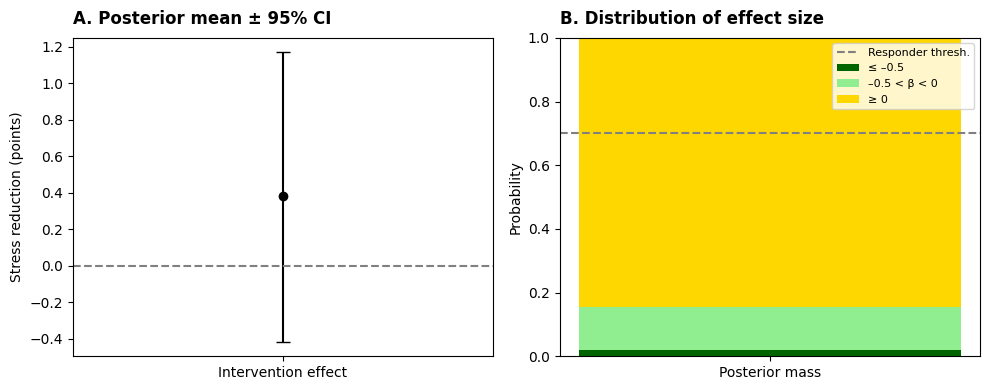

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 382 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.462  0.263    -0.032      0.967      0.011    0.009     565.0   
rho      -0.054  0.223    -0.507      0.360      0.008    0.008     758.0   
sigma     0.773  0.125     0.566      1.034      0.004    0.004     839.0   
beta_f1   0.597  0.109     0.397      0.815      0.005    0.004     398.0   

          ess_tail  r_hat  
beta_int     550.0   1.01  
rho          486.0   1.01  
sigma        519.0   1.00  
beta_f1      461.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 0.10%
P(beta_int ≤ –0.5) = 0.10%
P(–0.5 < beta_int < 0) = 3.70%
P(beta_int ≥ 0) = 96.20%


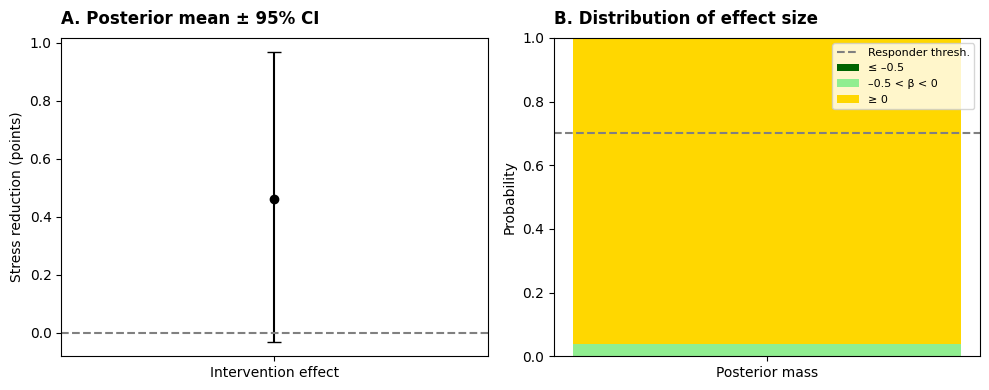

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 354 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.301  0.293    -0.904      0.238      0.013    0.011     572.0   
rho      -0.293  0.221    -0.705      0.132      0.009    0.007     586.0   
sigma     0.769  0.115     0.568      0.998      0.005    0.004     583.0   
beta_f2   0.613  0.102     0.416      0.819      0.005    0.003     453.0   

          ess_tail  r_hat  
beta_int     660.0    1.0  
rho          545.0    1.0  
sigma        645.0    1.0  
beta_f2      537.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 24.30%
P(beta_int ≤ –0.5) = 24.30%
P(–0.5 < beta_int < 0) = 61.60%
P(beta_int ≥ 0) = 14.10%


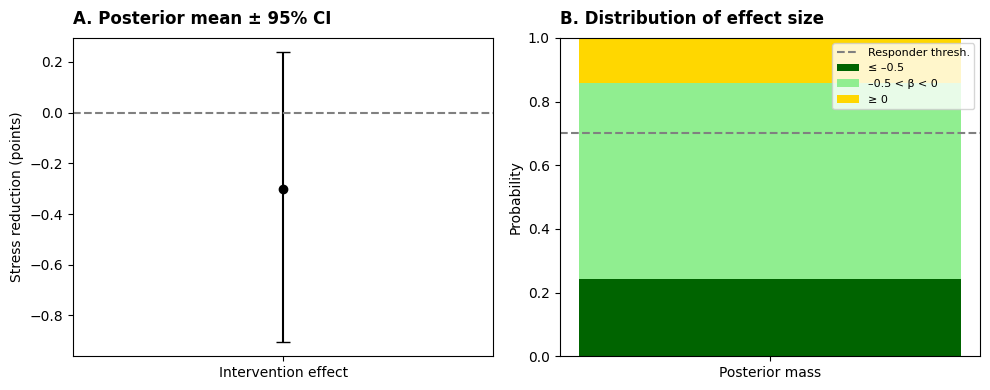

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 424 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.000  0.215    -0.410      0.433      0.009    0.008     577.0   
rho      -0.116  0.247    -0.615      0.335      0.010    0.009     588.0   
sigma     0.546  0.089     0.404      0.750      0.004    0.003     428.0   
beta_f1   0.415  0.085     0.243      0.576      0.003    0.003     614.0   
beta_f2   0.399  0.081     0.246      0.566      0.004    0.003     392.0   

          ess_tail  r_hat  
beta_int     508.0    1.0  
rho          521.0    1.0  
sigma        681.0    1.0  
beta_f1      575.0    1.0  
beta_f2      517.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 1.60%
P(beta_int ≤ –0.5) = 1.60%
P(–0.5 < beta_int < 0) = 47.70%
P(beta_int ≥ 0) = 50.70%


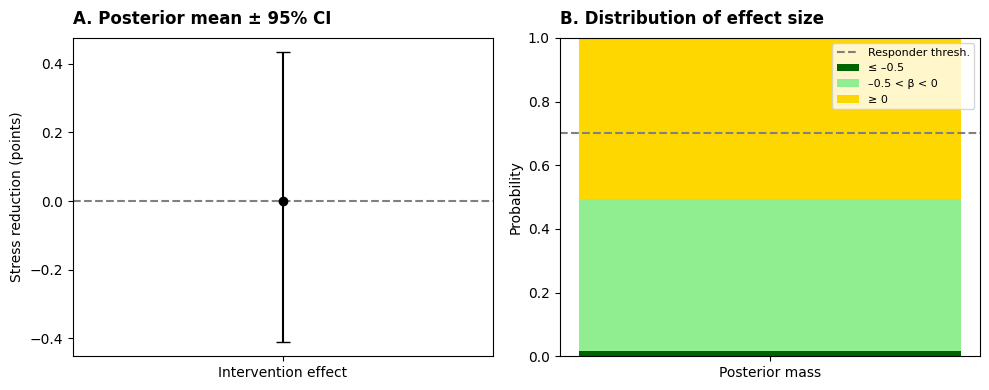

In [30]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Keeping a journal ").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Model: Only intervention


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 131 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.531  0.458    -0.394      1.408      0.018    0.017     676.0   
rho       0.045  0.235    -0.433      0.459      0.014    0.020     381.0   
sigma     1.211  0.195     0.865      1.559      0.009    0.010     576.0   

          ess_tail  r_hat  
beta_int     510.0   1.01  
rho          177.0   1.01  
sigma        465.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 1.10%
P(beta_int ≤ –0.5) = 1.10%
P(–0.5 < beta_int < 0) = 10.50%
P(beta_int ≥ 0) = 88.40%


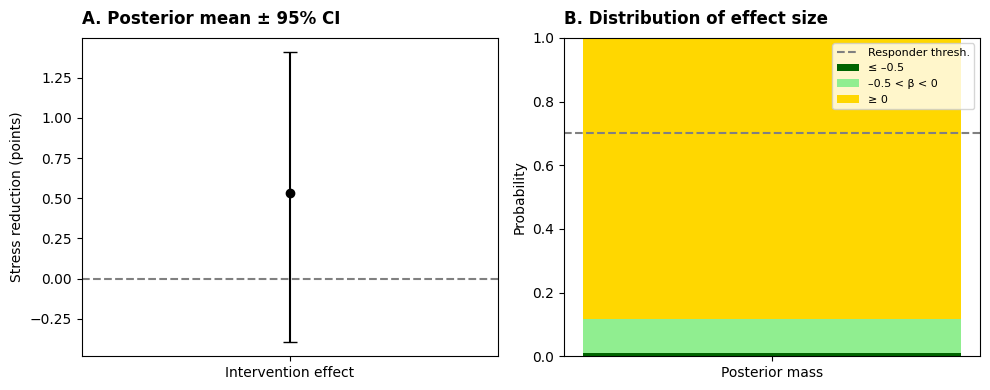


Model: Intervention + fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 250 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.492  0.316    -0.058      1.203      0.012    0.012     791.0   
rho      -0.048  0.213    -0.444      0.376      0.007    0.007     847.0   
sigma     0.775  0.126     0.566      1.016      0.005    0.005     692.0   
beta_f1   0.618  0.105     0.398      0.812      0.005    0.004     536.0   

          ess_tail  r_hat  
beta_int     459.0   1.01  
rho          532.0   1.01  
sigma        611.0   1.01  
beta_f1      520.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 0.30%
P(beta_int ≤ –0.5) = 0.30%
P(–0.5 < beta_int < 0) = 5.70%
P(beta_int ≥ 0) = 94.00%


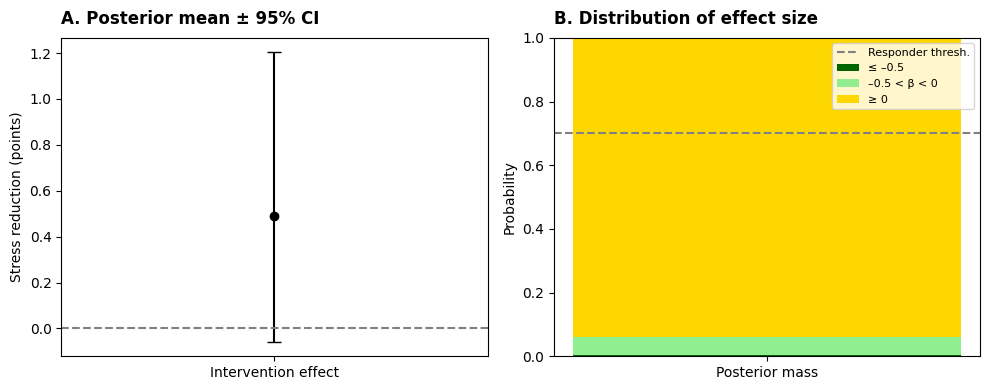


Model: Intervention + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 325 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.316  0.293    -0.820      0.338      0.015    0.011     403.0   
rho      -0.287  0.222    -0.701      0.147      0.010    0.009     458.0   
sigma     0.789  0.118     0.567      1.004      0.005    0.004     557.0   
beta_f2   0.629  0.103     0.425      0.817      0.005    0.003     442.0   

          ess_tail  r_hat  
beta_int     438.0   1.01  
rho          412.0   1.00  
sigma        632.0   1.00  
beta_f2      550.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 27.40%
P(beta_int ≤ –0.5) = 27.40%
P(–0.5 < beta_int < 0) = 59.10%
P(beta_int ≥ 0) = 13.50%


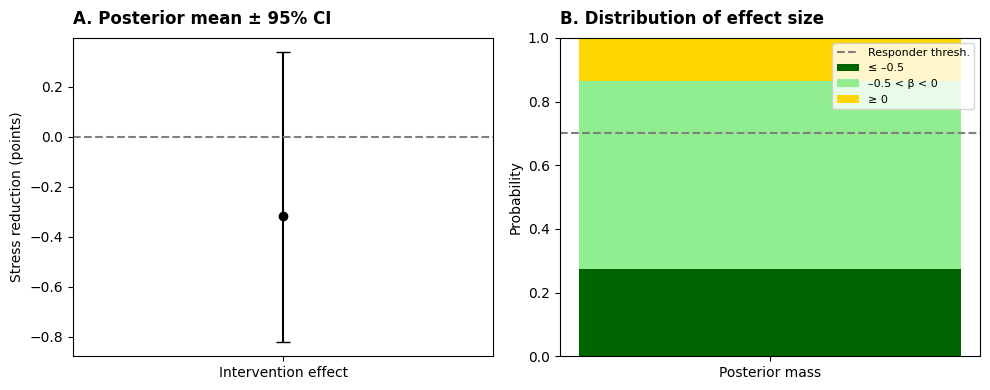


Model: Intervention + fac1 + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 409 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.020  0.234    -0.422      0.497      0.010    0.008     555.0   
rho      -0.114  0.234    -0.560      0.346      0.009    0.008     649.0   
sigma     0.550  0.090     0.404      0.743      0.003    0.003     701.0   
beta_f1   0.425  0.087     0.256      0.596      0.004    0.003     492.0   
beta_f2   0.397  0.085     0.228      0.559      0.004    0.003     515.0   

          ess_tail  r_hat  
beta_int     430.0   1.00  
rho          358.0   1.00  
sigma        789.0   1.00  
beta_f1      490.0   1.00  
beta_f2      507.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 0.90%
P(beta_int ≤ –0.5) = 0.90%
P(–0.5 < beta_int < 0) = 47.80%
P(beta_int ≥ 0) = 51.30%


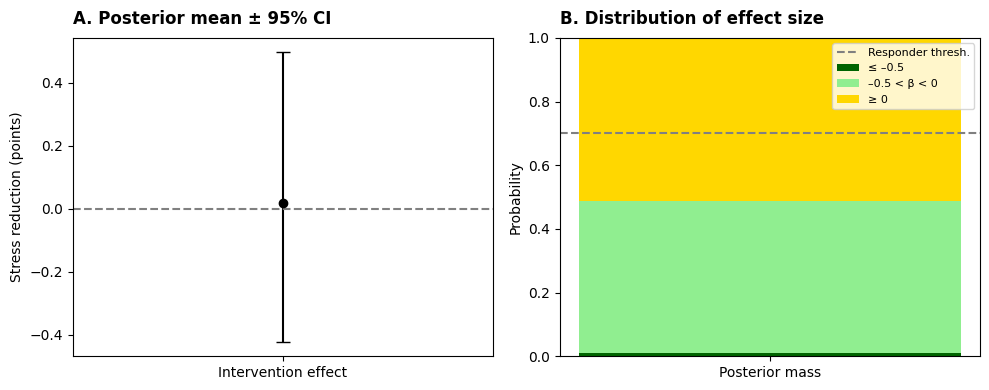

In [31]:
def run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Keeping a journal ").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    mad = np.median(np.abs(y - np.median(y)))
    scale = max(mad, 2.0)

    with pm.Model() as model:
        beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)
        beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)
        if include_fac1:
            beta_f1 = pm.StudentT('beta_f1', nu=3, mu=0, sigma=scale)
        if include_fac2:
            beta_f2 = pm.StudentT('beta_f2', nu=3, mu=0, sigma=scale)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Only intervention")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False)

print("\nModel: Intervention + fac1")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=False)

print("\nModel: Intervention + fac2")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=True)

print("\nModel: Intervention + fac1 + fac2")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Consecutive‐Day Adjustment

Only intervention:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 347 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.381  0.393    -0.392      1.143      0.015    0.011     682.0   
rho      -0.043  0.268    -0.535      0.511      0.009    0.010     870.0   
sigma     1.170  0.168     0.849      1.491      0.006    0.005     788.0   

          ess_tail  r_hat  
beta_int     733.0   1.00  
rho          598.0   1.02  
sigma        705.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 1.40%
P(beta_int ≤ –0.5) = 1.40%
P(–0.5 < beta_int < 0) = 14.80%
P(beta_int ≥ 0) = 83.80%


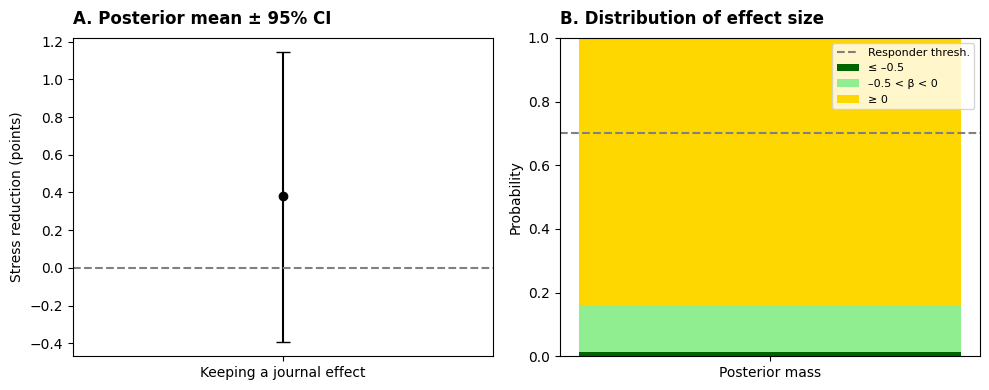


Intervention + fac1:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 551 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.471  0.294    -0.109      1.059      0.010    0.011     994.0   
rho      -0.085  0.311    -0.701      0.515      0.011    0.010     749.0   
sigma     0.758  0.113     0.570      0.996      0.005    0.004     604.0   
beta_f1   0.607  0.103     0.411      0.803      0.004    0.003     540.0   

          ess_tail  r_hat  
beta_int     585.0   1.00  
rho          527.0   1.00  
sigma        647.0   1.00  
beta_f1      694.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 0.10%
P(beta_int ≤ –0.5) = 0.10%
P(–0.5 < beta_int < 0) = 6.80%
P(beta_int ≥ 0) = 93.10%


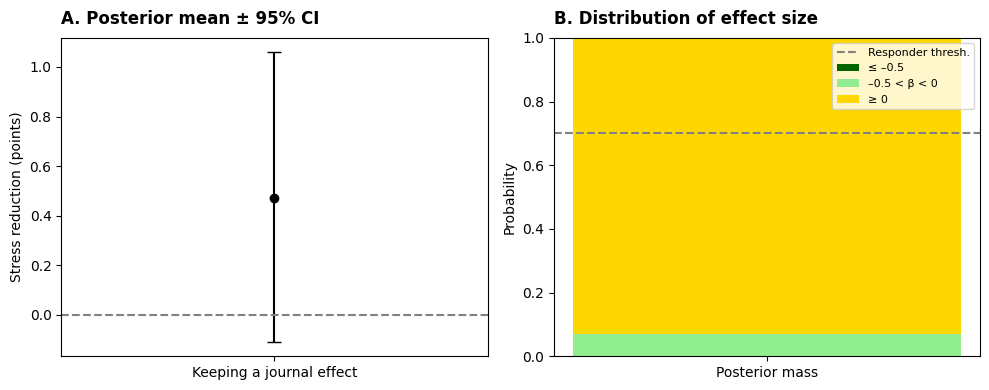


Intervention + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 631 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.288  0.272    -0.765      0.272      0.009    0.008     839.0   
rho      -0.386  0.211    -0.799      0.023      0.008    0.008     639.0   
sigma     0.750  0.116     0.550      0.992      0.004    0.004     729.0   
beta_f2   0.599  0.099     0.398      0.782      0.005    0.003     422.0   

          ess_tail  r_hat  
beta_int     804.0   1.00  
rho          412.0   1.00  
sigma        724.0   1.00  
beta_f2      754.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 21.10%
P(beta_int ≤ –0.5) = 21.10%
P(–0.5 < beta_int < 0) = 64.20%
P(beta_int ≥ 0) = 14.70%


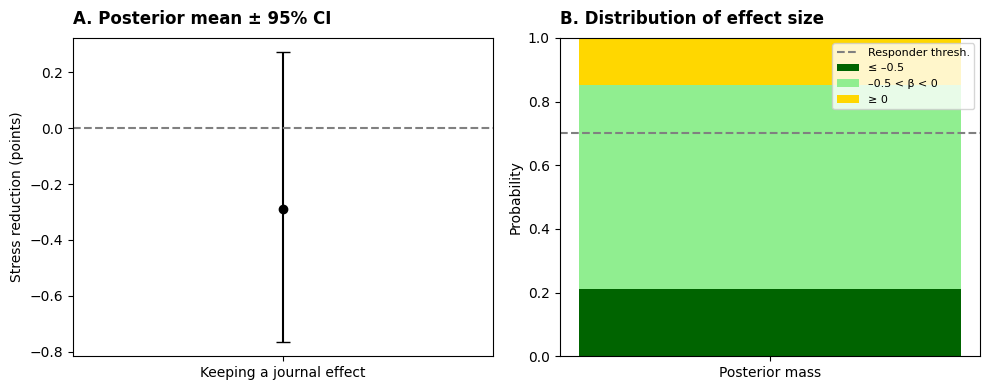


Intervention + fac1 + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 592 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.030  0.230    -0.380      0.522      0.009    0.008     648.0   
rho      -0.063  0.340    -0.631      0.687      0.016    0.010     456.0   
sigma     0.548  0.083     0.387      0.705      0.004    0.003     496.0   
beta_f1   0.428  0.098     0.242      0.615      0.005    0.003     479.0   
beta_f2   0.391  0.086     0.234      0.559      0.004    0.003     437.0   

          ess_tail  r_hat  
beta_int     611.0   1.01  
rho          498.0   1.00  
sigma        613.0   1.00  
beta_f1      630.0   1.00  
beta_f2      392.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 1.70%
P(beta_int ≤ –0.5) = 1.70%
P(–0.5 < beta_int < 0) = 42.30%
P(beta_int ≥ 0) = 56.00%


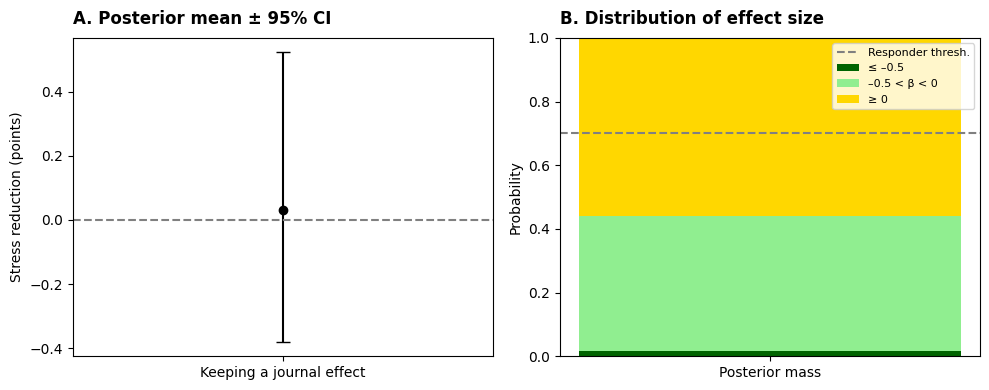

(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
 beta_int  0.030  0.230    -0.380      0.522      0.009    0.008     648.0   
 rho      -0.063  0.340    -0.631      0.687      0.016    0.010     456.0   
 sigma     0.548  0.083     0.387      0.705      0.004    0.003     496.0   
 beta_f1   0.428  0.098     0.242      0.615      0.005    0.003     479.0   
 beta_f2   0.391  0.086     0.234      0.559      0.004    0.003     437.0   
 
           ess_tail  r_hat  
 beta_int     611.0   1.01  
 rho          498.0   1.00  
 sigma        613.0   1.00  
 beta_f1      630.0   1.00  
 beta_f2      392.0   1.01  )

In [38]:
def run_ar1_model(df_mea, use_fac1=False, use_fac2=False):
    days_full = pd.DataFrame({'current_day_of_study': np.arange(0, 32)})

    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome'][
        ['current_day_of_study',
         'survey1_question1_response',   
         'current_intervention_name']
    ]
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators'][
        ['current_day_of_study',
         'survey2_question1_response',   
         'survey2_question2_response']   
    ]

    data = (
        days_full
        .merge(outcome_data,  on='current_day_of_study', how='left')
        .merge(mediator_data, on='current_day_of_study', how='left')
        .sort_values('current_day_of_study')
        .reset_index(drop=True)
    )

    days   = data['current_day_of_study'].values
    y      = data['survey1_question1_response'].values.astype(float)  
    n      = len(y)  

    interv = (data['current_intervention_name'] == "Keeping a journal ").astype(float).fillna(0).values

    if use_fac1:
        fac1 = data['survey2_question1_response'].values.astype(float)
        fac1 = np.nan_to_num(fac1, nan=0.0)
    else:
        fac1 = np.zeros_like(days, dtype=float)

    if use_fac2:
        fac2 = data['survey2_question2_response'].values.astype(float)
        fac2 = np.nan_to_num(fac2, nan=0.0)
    else:
        fac2 = np.zeros_like(days, dtype=float)

    obs_mask = ~np.isnan(y)
    consec   = np.zeros(n, dtype=float)
    consec[1:] = (obs_mask[1:] & obs_mask[:-1]).astype(float)

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if use_fac1:
            beta_f1  = pm.Normal('beta_f1',  mu=0, sigma=10)
        if use_fac2:
            beta_f2  = pm.Normal('beta_f2',  mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if use_fac1:
            mu = mu + beta_f1 * fac1
        if use_fac2:
            mu = mu + beta_f2 * fac2

        y_tt      = pt.constant(y)            
        mu_tt     = mu
        consec_tt = pt.constant(consec)

        def ar1_step(y_prev, mu_prev, mu_curr, consec_prev, rho):
            ar_term = pt.switch(pt.eq(consec_prev, 1.0), rho * (y_prev - mu_prev), 0.0)
            return mu_curr + ar_term

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu_tt[:-1], mu_tt[1:], consec_tt[:-1]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu_tt[0]], y_pred_scan], axis=0)

        y_obs_masked = np.ma.masked_invalid(y)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_obs_masked)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if use_fac1:
        var_names.append('beta_f1')
    if use_fac2:
        var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                             gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Keeping a journal effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left',
                 pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold',       label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left',
                 pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

    return trace, summary

print("Only intervention:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=False)

print("\nIntervention + fac1:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=False)

print("\nIntervention + fac2:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=True)

print("\nIntervention + fac1 + fac2:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=True)


#### Bayesian AR(1) Model of Daily Stress Response to Creating Literary Works and Mediators - Mean Imputation

In [33]:
imputed_data_o = df_mea[df_mea['measurement_name'] == 'Outcome'].copy()
imputed_data_o['current_day_of_study'] = imputed_data_o['current_day_of_study'].astype(int)

imputed_data_m = df_mea[df_mea['measurement_name'] == 'Mediators'].copy()
imputed_data_m['current_day_of_study'] = imputed_data_m['current_day_of_study'].astype(int)

days = pd.DataFrame({'current_day_of_study': range(0, 32)})

imputed_complete_o = days.merge(
    imputed_data_o, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)

imputed_complete_m = days.merge(
    imputed_data_m, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_m['measurement_name'].fillna('Mediators', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_21704\1570007407.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_21704\1570007407.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [34]:
df_o = imputed_complete_o.copy()
df_m = imputed_complete_m.copy()
pattern = (
    ['A'] * 4 +
    ['B'] * 8 +
    ['A'] * 4 +
    ['B'] * 4 +
    ['A'] * 8 +
    ['B'] * 4
)
txt = {
    'A': "Keeping a journal ",
    'B': "Not keeping a journal "
}

df_unique_o = (
    df_o
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_o = (
    df_unique_o
    .reindex(range(0, 32))                     
    .reset_index()                             
)

mask_o = df_fill_o['current_intervention_name'].isna()
df_fill_o.loc[mask_o, 'current_intervention_name'] = (
    df_fill_o.loc[mask_o, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

df_unique_m = (
    df_m
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_m = (
    df_unique_m
    .reindex(range(0, 32))                     
    .reset_index()                             
)

mask_m = df_fill_m['current_intervention_name'].isna()
df_fill_m.loc[mask_m, 'current_intervention_name'] = (
    df_fill_m.loc[mask_m, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

In [35]:
df_mean_imp_o = df_fill_o.copy()
df_mean_imp_m = df_fill_m.copy()
df_mean_imp_o['survey1_question1_response'] = (
    df_mean_imp_o
    .groupby('current_intervention_name')['survey1_question1_response']
    .transform(lambda grp: grp.fillna(grp.mean()))
)

cols_to_impute = [
    'survey2_question1_response',
    'survey2_question2_response'
]

for col in cols_to_impute:
    df_mean_imp_m[col] = (
        df_mean_imp_m
        .groupby('current_intervention_name')[col]
        .transform(lambda grp: grp.fillna(grp.mean()))
    )

Model: Neither fac1 nor fac2(intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 177 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.390  0.389    -0.320      1.266      0.015    0.012     677.0   
rho       0.101  0.199    -0.316      0.468      0.007    0.006     738.0   
sigma     1.066  0.143     0.788      1.325      0.006    0.005     613.0   

          ess_tail  r_hat  
beta_int     684.0    1.0  
rho          627.0    1.0  
sigma        472.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 1.30%
P(beta_int ≤ –0.5) = 1.30%
P(–0.5 < beta_int < 0) = 14.50%
P(beta_int ≥ 0) = 84.20%


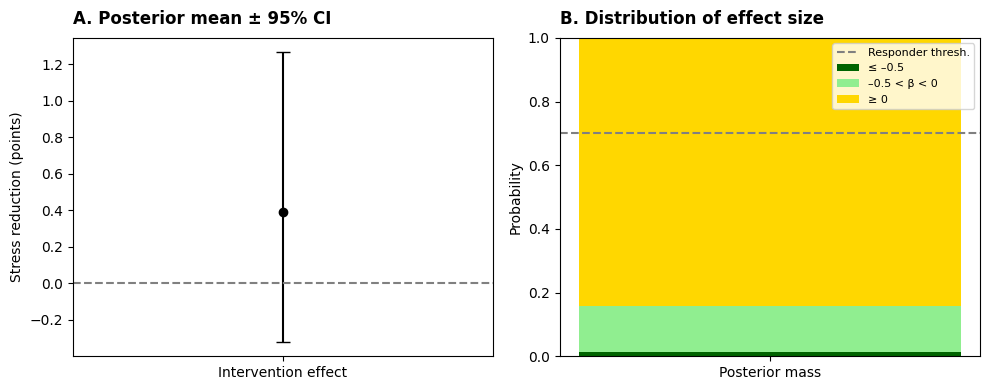

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 309 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.409  0.260    -0.099      0.969      0.010    0.010     759.0   
rho       0.051  0.203    -0.348      0.429      0.007    0.007     809.0   
sigma     0.715  0.097     0.547      0.908      0.004    0.004     611.0   
beta_f1   0.589  0.092     0.420      0.775      0.004    0.003     585.0   

          ess_tail  r_hat  
beta_int     489.0   1.00  
rho          695.0   1.01  
sigma        597.0   1.00  
beta_f1      504.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 0.00%
P(beta_int ≤ –0.5) = 0.00%
P(–0.5 < beta_int < 0) = 5.70%
P(beta_int ≥ 0) = 94.30%


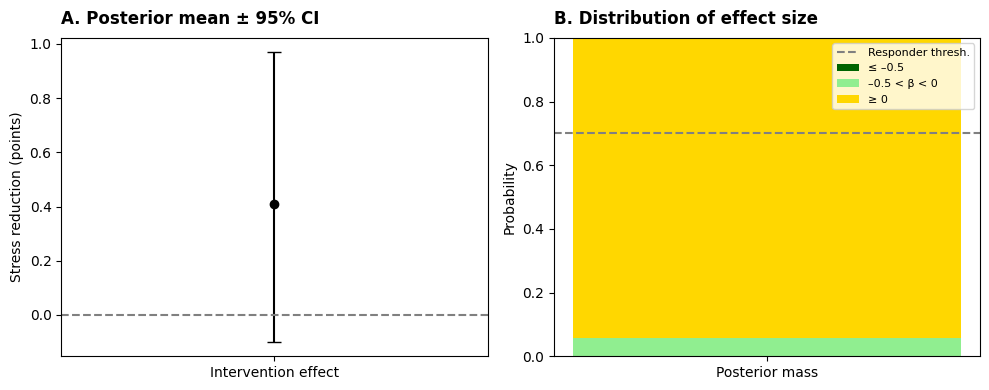

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 353 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.216  0.254    -0.715      0.258      0.012    0.009     439.0   
rho      -0.203  0.208    -0.584      0.217      0.009    0.007     597.0   
sigma     0.733  0.105     0.544      0.943      0.004    0.004     651.0   
beta_f2   0.582  0.100     0.390      0.801      0.005    0.005     382.0   

          ess_tail  r_hat  
beta_int     502.0    1.0  
rho          531.0    1.0  
sigma        497.0    1.0  
beta_f2      312.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 13.00%
P(beta_int ≤ –0.5) = 13.00%
P(–0.5 < beta_int < 0) = 68.30%
P(beta_int ≥ 0) = 18.70%


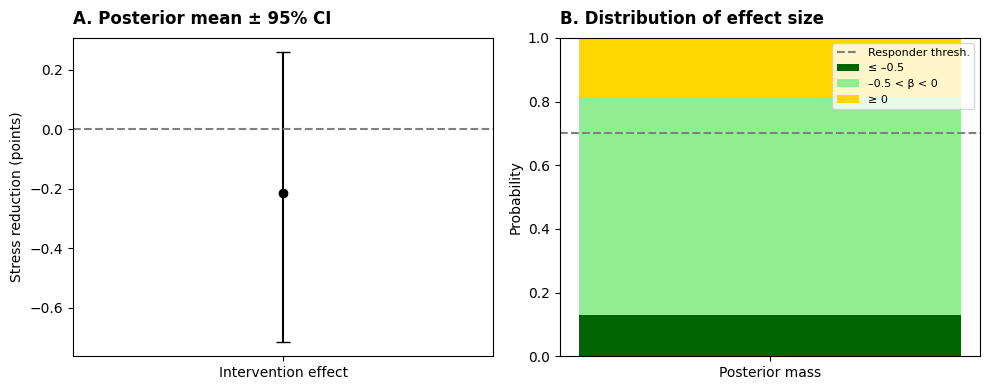

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 451 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.017  0.195    -0.361      0.431      0.007    0.006     696.0   
rho       0.056  0.232    -0.355      0.548      0.010    0.009     578.0   
sigma     0.520  0.078     0.384      0.670      0.003    0.004     698.0   
beta_f1   0.431  0.077     0.283      0.591      0.004    0.002     478.0   
beta_f2   0.378  0.075     0.208      0.510      0.004    0.003     420.0   

          ess_tail  r_hat  
beta_int     592.0   1.01  
rho          438.0   1.00  
sigma        608.0   1.00  
beta_f1      537.0   1.00  
beta_f2      584.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 0.50%
P(beta_int ≤ –0.5) = 0.50%
P(–0.5 < beta_int < 0) = 45.20%
P(beta_int ≥ 0) = 54.30%


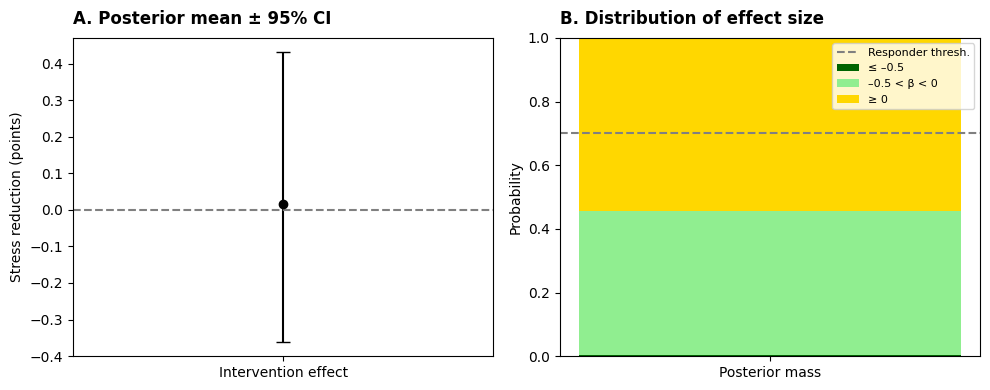

In [36]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mean_imp_o.copy()
    mediator_data = df_mean_imp_m.copy()

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Keeping a journal ").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2(intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Model of Daily Stress Response to Keeping a Journal and Mediators - Latent Variable Method

In [37]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    all_days = pd.DataFrame({'current_day_of_study': np.arange(0, 32)})
    outcome_data = pd.merge(all_days, outcome_data[merge_cols], on='current_day_of_study', how='left')
    if mediator_cols:
        mediator_data = pd.merge(all_days,
                                  mediator_data[['current_day_of_study'] + mediator_cols],
                                  on='current_day_of_study', how='left')
    else:
        mediator_data = all_days.copy()

    data = (pd.merge(outcome_data, mediator_data, on='current_day_of_study', how='left')
              .sort_values('current_day_of_study')
              .reset_index(drop=True))

    y_obs_raw = data['survey1_question1_response'].values
    y_obs = y_obs_raw.astype(float)
    interv = (data['current_intervention_name'] == "Keeping a journal ").astype(float).fillna(0.0)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None
    n = len(y_obs)

    nan_idx = np.isnan(y_obs)
    obs_idx = ~nan_idx
    missing_idx = np.where(nan_idx)[0].tolist()

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho   = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * pt.as_tensor_variable(np.nan_to_num(fac1, nan=0.0))
        if include_fac2:
            mu = mu + beta_f2 * pt.as_tensor_variable(np.nan_to_num(fac2, nan=0.0))

        y_latent = pm.Normal('y_latent', mu=0, sigma=10, shape=len(missing_idx))

        y_filled = pt.zeros(n)
        y_filled = pt.set_subtensor(y_filled[missing_idx], y_latent)
        y_filled = pt.set_subtensor(y_filled[obs_idx], y_obs[obs_idx])

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_filled[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1
        )
        y_pred = pt.concatenate([mu[:1], y_pred_scan], axis=0)

        pm.Normal('y_obs',
                  mu=y_pred[obs_idx],
                  sigma=sigma,
                  observed=y_obs[obs_idx])

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9,
                          return_inferencedata=True)

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1: var_names.append('beta_f1')
    if include_fac2: var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 622 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.449  0.430    -0.456      1.233      0.018    0.016     572.0   
rho       0.037  0.129    -0.181      0.312      0.009    0.005     201.0   
sigma     1.122  0.170     0.836      1.471      0.007    0.007     592.0   

          ess_tail  r_hat  
beta_int     569.0   1.00  
rho          317.0   1.01  
sigma        593.0   1.01  
P(beta_int ≤ –0.5) = 1.10%
P(–0.5 < beta_int < 0) = 12.30%
P(beta_int ≥ 0) = 86.60%
Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 918 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.441  0.272    -0.094      0.973      0.011    0.009     571.0   
rho       0.075  0.129    -0.209      0.282      0.031    0.012      24.0   
sigma     0.645  0.114     0.441      0.860      0.005    0.004     619.0   
beta_f1   0.628  0.100     0.448      0.847      0.005    0.004     393.0   

          ess_tail  r_hat  
beta_int     434.0   1.01  
rho          101.0   1.07  
sigma        671.0   1.00  
beta_f1      420.0   1.00  
P(beta_int ≤ –0.5) = 0.00%
P(–0.5 < beta_int < 0) = 5.90%
P(beta_int ≥ 0) = 94.10%
Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 935 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -0.187  0.338    -0.864      0.431      0.009    0.012    1411.0   
rho      -0.019  0.070    -0.172      0.103      0.003    0.003     444.0   
sigma     0.803  0.120     0.580      1.030      0.004    0.004    1073.0   
beta_f2   0.570  0.114     0.322      0.776      0.004    0.004     794.0   

          ess_tail  r_hat  
beta_int     692.0   1.00  
rho          389.0   1.01  
sigma        694.0   1.01  
beta_f2      816.0   1.00  
P(beta_int ≤ –0.5) = 17.70%
P(–0.5 < beta_int < 0) = 52.40%
P(beta_int ≥ 0) = 29.90%
Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1060 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.009  0.203    -0.412      0.380      0.007    0.007     842.0   
rho       0.016  0.109    -0.183      0.202      0.017    0.002      49.0   
sigma     0.453  0.079     0.321      0.618      0.003    0.002     622.0   
beta_f1   0.498  0.080     0.356      0.661      0.003    0.003     624.0   
beta_f2   0.359  0.075     0.230      0.525      0.003    0.003     697.0   

          ess_tail  r_hat  
beta_int     631.0   1.00  
rho          432.0   1.04  
sigma        751.0   1.00  
beta_f1      509.0   1.01  
beta_f2      631.0   1.00  
P(beta_int ≤ –0.5) = 0.90%
P(–0.5 < beta_int < 0) = 46.80%
P(beta_int ≥ 0) = 52.30%
